In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from math import sqrt
from numpy import split
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import GRU
from keras.layers import Bidirectional
from keras_tuner import RandomSearch
from keras_tuner import Hyperband
from keras_tuner import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

In [2]:
import random
random.seed(123)

Cargamos el notebook que contiene las funciones que usaremos

In [3]:
%run Funciones_Temp.ipynb

3.8.3


In [9]:
n_obs_antes = 3
n_obs_despues = 6
pred_steps = 6
block = ['A','B','C']
#data = datos
path = 'modelos/'
variables = 1 
keras.models.load_model(path + 'model_temp_bilstm_0'+ str(variables) + '_predsteps' + '6' + '_post' + str(n_obs_despues) + '_prev' + str(n_obs_antes) + '.h5')

Cargamos los datos con la información de todas las habitaciones con muestras cada 10 minutos

In [4]:
datos = pd.read_csv("data-room-10T-all.csv", sep = ";", index_col=0)

Definimos una función que haga todo el proceso, utilizando las funciones del notebook importado

In [5]:
def prueba(obs_antes, obs_despues, pred_steps, block, data, variable_mode):
    edificio = block
    n_obs_antes = obs_antes
    n_obs_despues = obs_despues
    n_predict = pred_steps #Timesteps a predecir
    datos = data
    variables = variable_mode
    interval = n_obs_antes + n_obs_despues
    path = 'modelos/'
    
    #Busqueda de patrón ON->OFF
    datos_all_rooms = find_events(datos, edificio, n_obs_antes, n_obs_despues, variables)
    
    df = datos_all_rooms
    #Reordenar muestras aleatoriamete
    df = shuffle_df(df, interval)
    
    #Split en train/val/test (70/15/15)
    per_train = 0.7
    per_test = 0.15
    train, test, val, scaler_x, scaler_y = split_dataset(df, per_train, per_test, interval, n_obs_antes, n_obs_despues)
   
    #Convertimos datos a aprendizaje supervisado
    n_input = n_obs_antes
    n_out = 1
    train_x, train_y = to_supervised(train, n_input, n_out)
    test_x, test_y = to_supervised(test, n_input, n_out)
    val_x, val_y = to_supervised(val, n_input, n_out)
    
    #Quitamos muestras mezcladas
    train_x, train_y, test_x, test_y, val_x, val_y = fix_samples(n_obs_despues, n_obs_antes, train_x, test_x, val_x, train_y, test_y, val_y)
    
    #Para la forma del input de la red
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

    #-----------------------Diseño del modelo-------------------- Lo hacemos aquí porque da problemas al usarlo desde el nb
    #Si n_pred es 12 y n_obs_despues es 12 cargamos el mismo modelo con n_pred=6 y n_obs_despues=12
    if n_obs_despues == n_predict == 12:
        model = keras.models.load_model(path + 'model_temp_bilstm_0'+ str(variables) + '_predsteps' + '6' + '_post' + str(n_obs_despues) + '_prev' + str(n_obs_antes) + '.h5')
    #Si no estamos en ese caso hacemos el modelo
    else:
        def build_model(hp):
            model = Sequential()
            hp_units = hp.Choice('input_unit',[32,64,128])
            model.add(Bidirectional(LSTM(units = hp_units, input_shape=(n_timesteps, n_features))))
            model.add(RepeatVector(n_outputs))   
            for i in range(hp.Int('n_layers', 1, 2)):
                units_i = hp.Choice(f'dense_{i}_units',[32,64,128])
                model.add(Bidirectional(LSTM(units = units_i, return_sequences=True)))
            hp_dropout = hp.Float('Dropout_rate',min_value=0,max_value=0.4,step=0.1)
            model.add(Dropout(hp_dropout))
            model.add(TimeDistributed(Dense(units = hp_units)))
            model.add(TimeDistributed(Dense(n_outputs)))
            hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
            model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
            return model

        tuner= BayesianOptimization(build_model,
                                    objective='val_loss', max_trials=15, num_initial_points=2, overwrite=True)
        stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
        tuner.search(x=train_x, y=train_y, epochs=200, batch_size=128, validation_data=(val_x,val_y),verbose=2, shuffle=False, callbacks=[stop_early])
        model = tuner.get_best_models(num_models=1)[0]
    #------------------------------------------------------------------------------------------------------------
    
    #Predicciones
    prediction, test_y = predict(test_x, test_y, n_predict, n_obs_despues, model, n_timesteps, n_features, n_input)
    
    #Reshape para poder calcular métricas
    pred_shape_0 = test.shape[0]
    pred_shape_1 = n_predict
    prediction = prediction.reshape(pred_shape_0, pred_shape_1)
    test_y = test_y.reshape(pred_shape_0, pred_shape_1)
    prediction = scaler_y.inverse_transform(prediction)
    test_y = scaler_y.inverse_transform(test_y)
    
    #Cálculamos métricas
    differences = np.abs(prediction-test_y).mean(axis=1)
    #differences = np.abs((prediction - test_y).mean(axis=1)).round(0).astype(int)
    cvrmse, r2, rmse = metrics(test_y, prediction)
    
    return model, cvrmse, r2, rmse, differences, test_y, prediction

In [6]:
obs_antes = 3
obs_despues = 6
pred_steps = 6
block = ['A','B','C']
data = datos
var_mode = 1 # 1 = temp, 2 = temp+meteo, 3 = all
model, cvrmse, r2, rmse, differences, test_y, prediction = prueba(obs_antes, obs_despues, pred_steps, block, data, var_mode)

Trial 20 Complete [00h 00m 28s]
val_loss: 0.0883907675743103

Best val_loss So Far: 0.08597306162118912
Total elapsed time: 00h 14m 39s
INFO:tensorflow:Oracle triggered exit


In [271]:
model.save('model_temp_bilstm_0'+ str(var_mode) + '_predsteps' + str(pred_steps) + '_post' + str(obs_despues) + '_prev' + str(obs_antes) + '.h5')

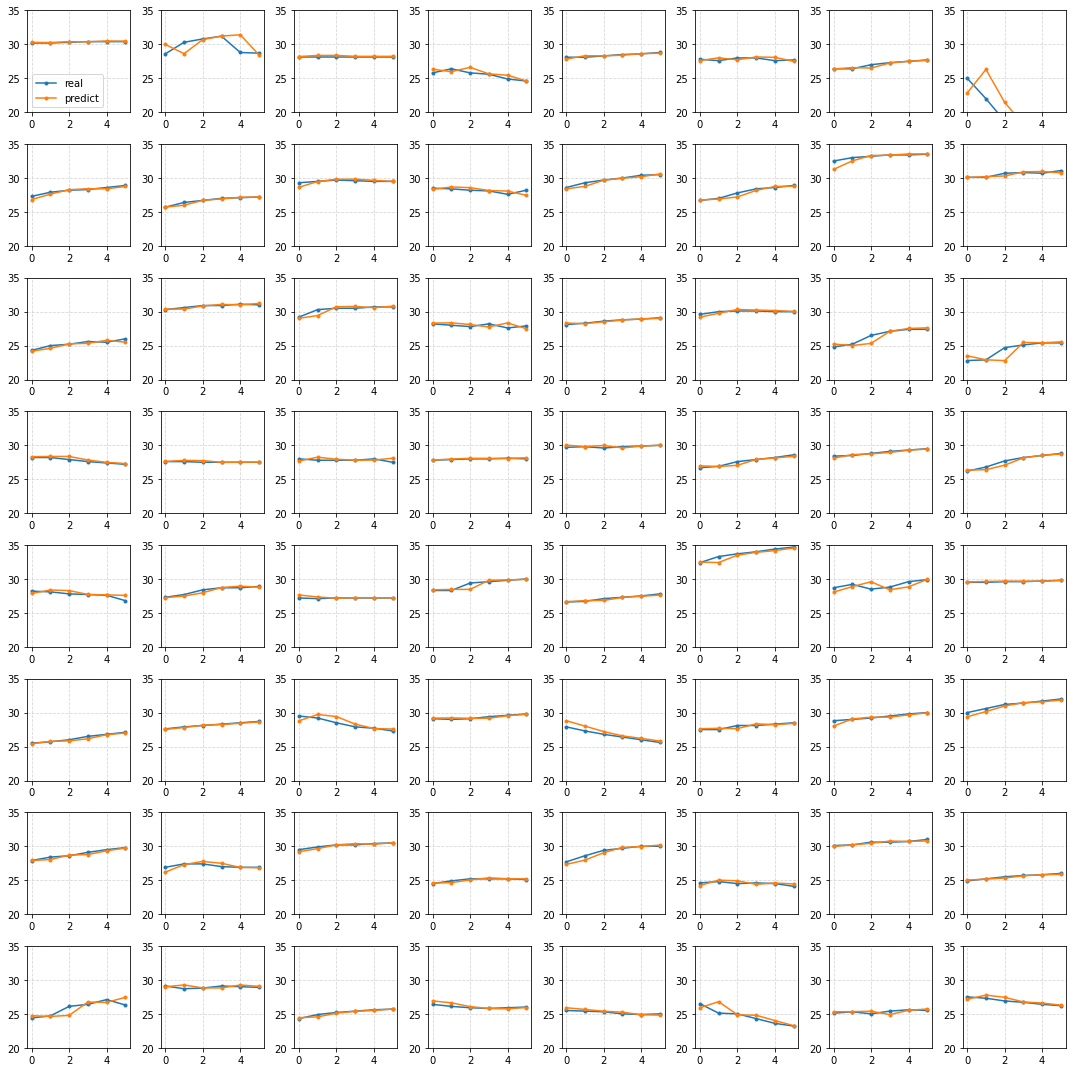

In [7]:
fig, axs = plt.subplots(figsize=(15,15), nrows = 8, ncols =8)
i=0
j=0
k=0
for i in range(0,8):
    for j, k in enumerate(range(k,k+8)):
        #print([i,j,k])
        axs[i,j].plot(test_y[k+i,:], label = 'real', marker='.')
        axs[i,j].plot(prediction[k+i,:], label = 'predict', marker='.')
        axs[i,j].set_ylim(20,35)
        axs[i,j].grid(linestyle = "--", alpha=0.5)
        axs[0,0].legend()
    fig.tight_layout()
plt.show()

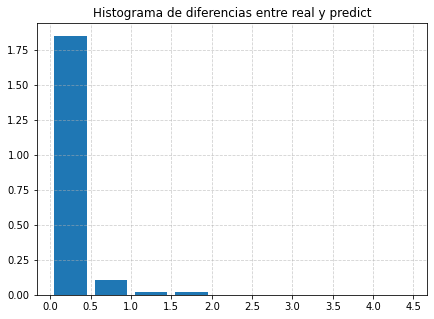

In [8]:
fig = plt.figure(figsize =(7, 5))
plt.grid(linestyle = "--", alpha=0.6)
plt.xticks(np.arange(0, 5, 0.5))
plt.hist(differences, bins=np.arange(0,5,0.5) , density=True, rwidth=0.8, align='mid')
plt.title("Histograma de diferencias entre real y predict")
plt.show()

In [277]:
results = pd.read_csv('model-temp-results.csv', sep=";")
results

,Modelo,Variables,steps_pred,n_obs_despues,n_obs_antes,CVRMSE,R2,RMSE,test_y,prediction,differences
0,LSTM,temp,6,6,1,1.294291,0.980545,0.360898,"[array([[29.4, 29.4, 29.7, 30.2, 30.3, 30.7],\...","[array([[29.794888, 29.613064, 29.613064, 29.9...","[array([0.21275806, 0.18390236, 0.14103171, 0...."
1,LSTM,temp,6,6,3,1.203933,0.977694,0.340846,"[array([[24.6, 24.9, 24.6, 24.2, 23.8, 23.7],\...","[array([[24.310104, 24.821795, 25.015211, 24.5...","[array([0.23544528, 0.16980896, 0.28656419, 0...."
2,LSTM,temp,6,6,6,1.252094,0.968989,0.354052,"[array([[30.5, 30.4, 30.5, 30.7, 30.8, 30.7],\...","[array([[30.57816 , 30.634714, 30.573544, 30.6...","[array([0.11720956, 0.17448101, 0.21919219, 0...."


In [9]:
add = {'Modelo': 'BiLSTM', 'Variables': 'temp', 'steps_pred': pred_steps, 'n_obs_despues': obs_despues, 'n_obs_antes': obs_antes, 'CVRMSE': cvrmse, 'R2': r2, 'RMSE': rmse}
#results = results.append(add, ignore_index = True)

In [10]:
add

{'Modelo': 'BiLSTM',
 'Variables': 'temp',
 'steps_pred': 6,
 'n_obs_despues': 6,
 'n_obs_antes': 3,
 'CVRMSE': 1.5059616333702375,
 'R2': 0.9625313771701984,
 'RMSE': 0.42632064948077814}

In [276]:
results.to_csv('model-temp-results.csv', sep=";", index=False)

In [246]:
#results = pd.DataFrame(columns=['Modelo', 'Variables', 'steps_pred', 'n_obs_despues', 'n_obs_antes', 'CVRMSE', 'R2', 'RMSE', 'test_y', 'prediction','differences'])

In [6]:
obs_antes = [1,3,6] #1,3,6
obs_despues = [12]   #6,12
pred_steps = [12]    #6,12
block = ['A','B','C']
data = datos
var_mode = [1,2,3] # 1 = temp, 2 = temp+meteo, 3 = all

for i in obs_antes:
    for j in obs_despues:
        for k in pred_steps:
            for l in var_mode:
                print('obs_antes:', i, '| obs_despues', j, '| pred_steps:', k, '| var_mode', l)
                model, cvrmse, r2, rmse, differences, test_y, prediction = prueba(i, j, k, block, data, l)
                model.save('model_temp_bilstm_0'+ str(l) + '_predsteps' + str(k) + '_post' + str(j) + '_prev' + str(i) + '.h5')
                results_metrics = pd.read_csv('model-temp-results_metrics.csv', sep=";")
                add_metrics = {'Modelo': 'BiLSTM', 'Variables': '0'+str(l), 'steps_pred': k, 'n_obs_despues': j, 'n_obs_antes': i, 'CVRMSE': cvrmse, 'R2': r2, 'RMSE': rmse}
                results_metrics = results_metrics.append(add_metrics, ignore_index = True)
                results_metrics.to_csv('model-temp-results_metrics.csv', sep=";", index=False)
                results_preds = pd.read_csv('model-temp-results_preds.csv', sep=";")
                prediction = prediction.round(2)
                differences = differences.round(2)
                add_preds = pd.DataFrame({'Prueba': np.repeat('BiLSTM-' + str(l) + '-' + str(k) +'-' + str(j) + '-' + str(i), len(test_y)),
                                        'test_y': test_y.tolist(),'prediction': prediction.tolist(),'difference': differences.tolist()})
                results_preds = pd.concat([results_preds, add_preds])
                results_preds.to_csv('model-temp-results_preds.csv', sep=";", index=False)
                print('Paso', i, j, k, l)

obs_antes: 1 | obs_despues 12 | pred_steps: 12 | var_mode 1
Paso 1 12 12 1
obs_antes: 1 | obs_despues 12 | pred_steps: 12 | var_mode 2
Paso 1 12 12 2
obs_antes: 1 | obs_despues 12 | pred_steps: 12 | var_mode 3
Paso 1 12 12 3
obs_antes: 3 | obs_despues 12 | pred_steps: 12 | var_mode 1
Paso 3 12 12 1
obs_antes: 3 | obs_despues 12 | pred_steps: 12 | var_mode 2
Paso 3 12 12 2
obs_antes: 3 | obs_despues 12 | pred_steps: 12 | var_mode 3
Paso 3 12 12 3
obs_antes: 6 | obs_despues 12 | pred_steps: 12 | var_mode 1
Paso 6 12 12 1
obs_antes: 6 | obs_despues 12 | pred_steps: 12 | var_mode 2
Paso 6 12 12 2
obs_antes: 6 | obs_despues 12 | pred_steps: 12 | var_mode 3
Paso 6 12 12 3
